# Домашнее задание №3: Facebook Prophet для прогнозирования временных рядов 

In [2]:
%pylab inline

import time
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import math
import pandas.tseries.offsets as ofs
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools

import warnings as w
# import plotly.plotly as py
from chart_studio import plotly as py

%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from fbprophet import Prophet
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

Загрузим данные. Они содержат интервал с пропущенными значениями. Выделим отдельно временной ряд `ts_no_outs` без большого пропуска. По умолчанию будем работать с ним.

In [73]:
ts = pd.read_csv(r'C:\Users\79196\1Notebook\University\DZ\dz4\dataset1_with_outliers_data.csv')
ts.index = pd.to_datetime(ts['ds'])
ts.sort_index(inplace=True)

ts_test = ts[datetime(2015,1,1):]

ts_full = ts[:datetime(2015,1,1)]
ts_no_outs = ts_full[datetime(2012, 1,1):]

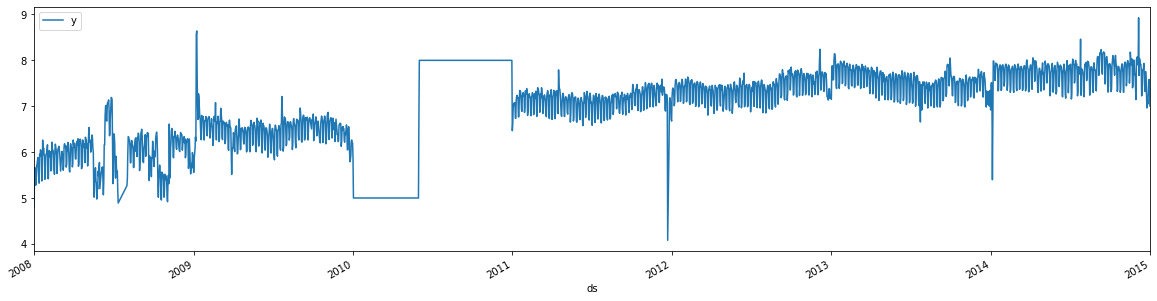

In [74]:
ts_full.plot(figsize=(20,5))

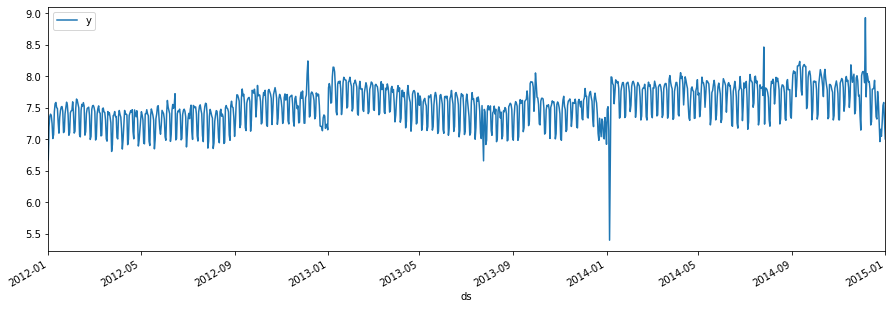

In [75]:
ts_no_outs.plot(figsize=(15,5))

### Часть 0. Разогрев.
Для выполнения этого задания полезно будет обратиться к [официальной документации](https://facebook.github.io/prophet/docs/quick_start.html) Facebook Prophet.


In [76]:
# ts_no_outs.drop(['ds'], axis='columns', inplace=True)
ts_no_outs

,ds,y
ds,,
2012-01-01,2012-01-01,6.675823
2012-01-02,2012-01-02,7.194437
2012-01-03,2012-01-03,7.362645
2012-01-04,2012-01-04,7.396949
2012-01-05,2012-01-05,7.374629
...,...,...
2014-12-28,2014-12-28,7.270313
2014-12-29,2014-12-29,7.534763
2014-12-30,2014-12-30,7.582229


### Часть 1. Проверка ряда на стационарность (20%)

Проверьте ряд на стационарность (например, с помощью критерия [Дики-Фуллера](https://ru.wikipedia.org/wiki/Тест_Дики_—_Фуллера)). Попробуйте привести его к стационарному виду (с помощью преобразования Бокса-Кокса, дифференцирования etc.)

После получения стационарного ряда напишите функцию прямой `transform` и обратной `inv_transform` трансформации временного ряда (т.е. исходный ряд -> стационарный ряд и стационарный ряд -> исходный ряд).

In [77]:
print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(ts_no_outs['y'])[1])

 Критерий Дики-Фуллера: p=0.074175


In [78]:
def transform(df):
    plt.figure(figsize=(15,10))
    sm.tsa.seasonal_decompose(df['y'], freq = 30).plot()
    print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['y'])[1])
    

# def inv_transform(ts):
    ### Your code here

### Часть 2. Обнаружение выбросов (10%).
С помощью экспоненциального сглаживания найдите выбросы в данных (и попробуйте их сгладить). Для этого подберите оптимальные значения параметров `alpha`, `beta` и `std_window`. Функция для детекции аномалий и сглаживания приведена ниже. Обратите внимание, мы работаем лишь с `ts_train`, тестовый датасет `ts_test` "находится в будущем" и нам недоступен.

In [79]:
def exponential_smoothing_anomaly_filter(series, alpha, beta=2.5, std_window=10):
    """
    Anomaly filter based on simple exponential smoothing.

    Parameters
    ----------
    series : pandas.Series
        Time series to smooth.
    alpha : float in range [0., 1.]
        Smoothing parameter. The smaller is `alpha`, the smoother are result series.
    beta: float
        Multiplier for rolling standard deviation. If the deviation from smoothed time series 
        in some point is bigger
        than `beta`*rolling_std, that point is marked as anomaly.
    std_window : int
        Rolling std window width.

    Returns
    -------
    _ : pandas.Series
        Smoothed time series.
    _ : pandas.Series
        Series containing anomalies (both time and value).
    """


    result = [series[0]] # first value is same as series
    sx = series.rolling(std_window).std()
    anomalies_index = []
    anomalies_values = []
#     print(len(series), len(sx))
    for n in range(1, len(series)):
        if n > std_window:
            if abs(series[n] - result[n-1]) > sx[n]*beta:
                result.append(result[n-1])
                anomalies_index.append(series.index[n])
                anomalies_values.append(series[n])
                continue
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(index=series.index, data=result), pd.Series(index=anomalies_index, data=anomalies_values)

In [80]:
# %%time

# a = 0
# b = 0
# std = 0
# best_d = 1
# is_good = False
# dk = 1

# while (a < 1.01):
#     if (is_good):
#             break
#     while(b < 20):
#         if (is_good):
#             break
#         std = 0
#         while(std < 100):
#             time.sleep(1)
#             ts_no_outs['ty'], ts_no_outs['ay'] = exponential_smoothing_anomaly_filter(ts_no_outs['y'], a, b, std)
#             time.sleep(1)
#             std = std + 1
#             time.sleep(1)
#             dk = sm.tsa.stattools.adfuller(ts_no_outs['ty'])[1]
#             time.sleep(1)
#             print('dk: {}, parameters: {},{},{}'.format(dk, a, b, std))
#             if (dk < best_d):
#                 best_d = dk
#                 best_a = a
#                 best_b = b
#                 best_s = std
#                 print('new best!')
#             if (dk < 0.00001):
#                 is_good = True
#                 break
#         b = b + 0.1
#     a = a + 0.1

# print('dk: {}, parameters: {},{},{}'.format(best_d, best_a, best_b, best_s))

In [81]:
ts_no_outs['ty'], ts_no_outs['ay'] = exponential_smoothing_anomaly_filter(ts_no_outs['y'], 0.35, 1.5, 29)
dk = sm.tsa.stattools.adfuller(ts_no_outs['ty'])[1]
dk

0.01918734883565836

 Критерий Дики-Фуллера: p=0.019187


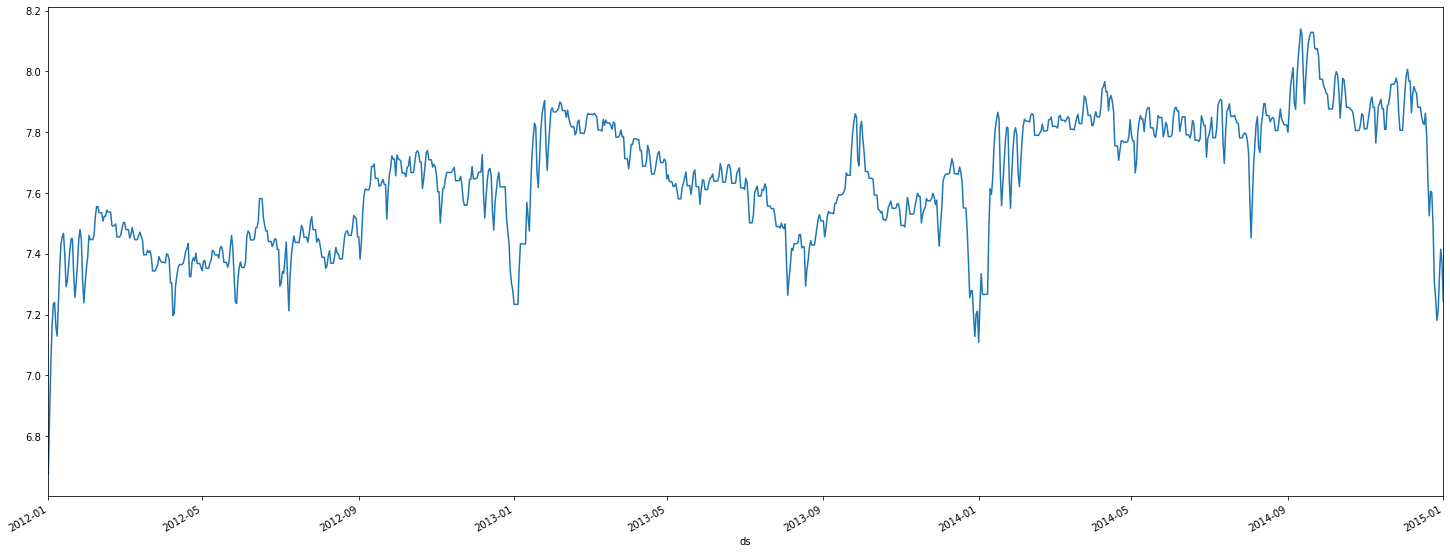

In [82]:
plt.figure(figsize=(25,10))
ts_no_outs['ty'].plot()
print(" Критерий Дики-Фуллера: p=%f" % dk)

### Часть 3. Построение прогнозов с помощью библиотеки Facebook Prophet (50%)

#### Построение прогноза (25%)

Сделайте предсказание на год вперед на основании `ts_no_outs` и `ts_full`. Для этого вам пригодится функция `make_future_dataframe()`.

## ts_no_outs

In [83]:
ts_no_outs

,ds,y,ty,ay
ds,,,,
2012-01-01,2012-01-01,6.675823,6.675823,NaN
2012-01-02,2012-01-02,7.194437,6.857338,NaN
2012-01-03,2012-01-03,7.362645,7.034196,NaN
2012-01-04,2012-01-04,7.396949,7.161159,NaN
2012-01-05,2012-01-05,7.374629,7.235874,NaN
...,...,...,...,...
2014-12-28,2014-12-28,7.270313,7.212458,NaN
2014-12-29,2014-12-29,7.534763,7.325265,NaN
2014-12-30,2014-12-30,7.582229,7.415202,NaN


In [84]:
fmodel = Prophet()


fmodel.fit(ts_no_outs)
future = fmodel.make_future_dataframe(periods=365)

forecast = fmodel.predict(future)

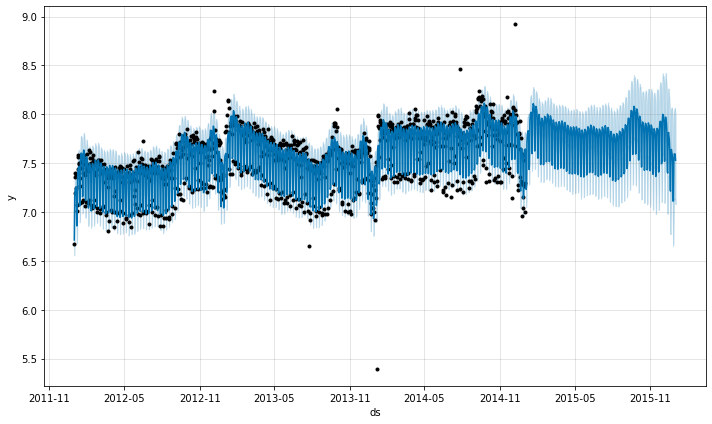

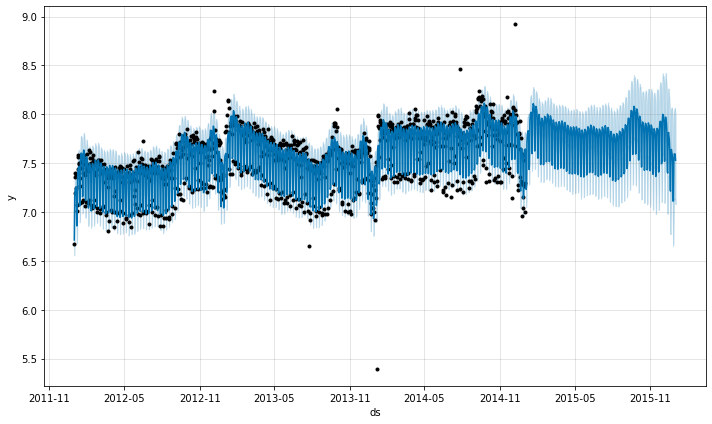

In [85]:
fmodel.plot(forecast)

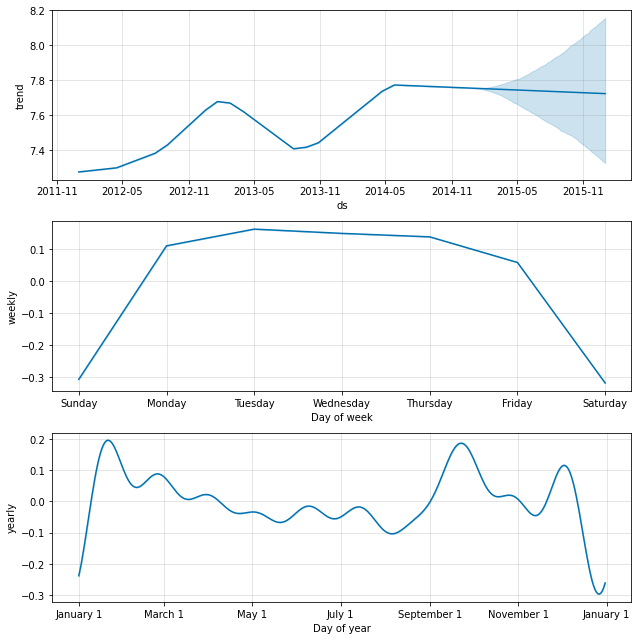

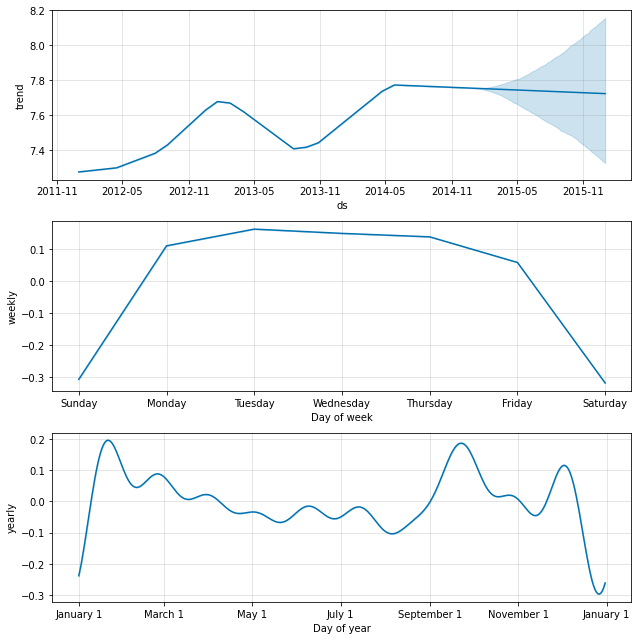

In [86]:
fmodel.plot_components(forecast)

## ts_full

In [87]:
fmodel1 = Prophet()

fmodel1.fit(ts_full)
future1 = fmodel1.make_future_dataframe(periods=365)

forecast1 = fmodel1.predict(future1)

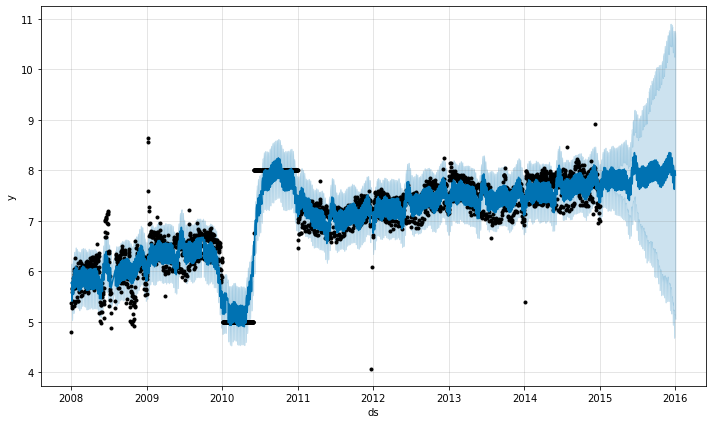

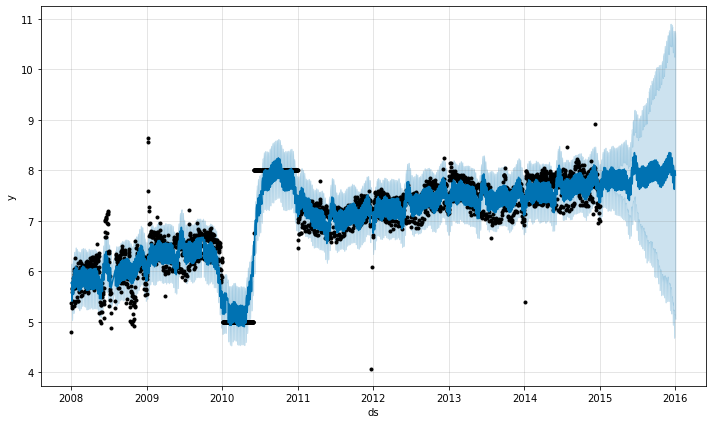

In [88]:
fmodel1.plot(forecast1)

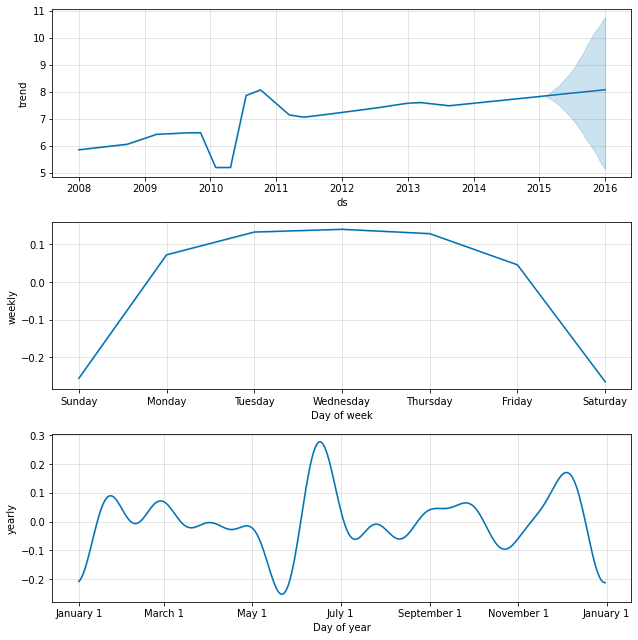

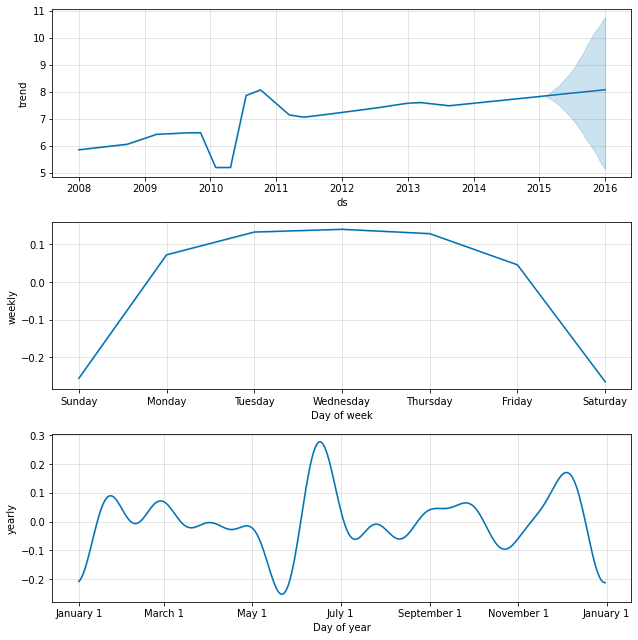

In [89]:
fmodel1.plot_components(forecast1)

Оцените качество прогноза с помощью MSE, MAE и $r^2$-score (т.е. сравните прогноз с реальным поведением временного ряда). Для этого может быть полезна функция `make_comparison_dataframe` (приведенная в [статье](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-part-3-predicting-the-future-with-facebook-prophet-3f3af145cdc)).

In [90]:
# from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [91]:
cmp_df  = make_comparison_dataframe(ts_no_outs, forecast)

In [92]:
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MSE {}'.format(np.mean(abs(cmp_df[datetime(2015,1,1):]['p']))))
print('MAE {}'.format(np.mean(abs(cmp_df[datetime(2015,1,1):]['e']))))

MSE 9.14816920339392
MAE 0.6407354049893392


Также визуально оцените дисперсию прогноза в случае обучения на `ts_no_outs` и на `ts_full`. 

ts_no_out

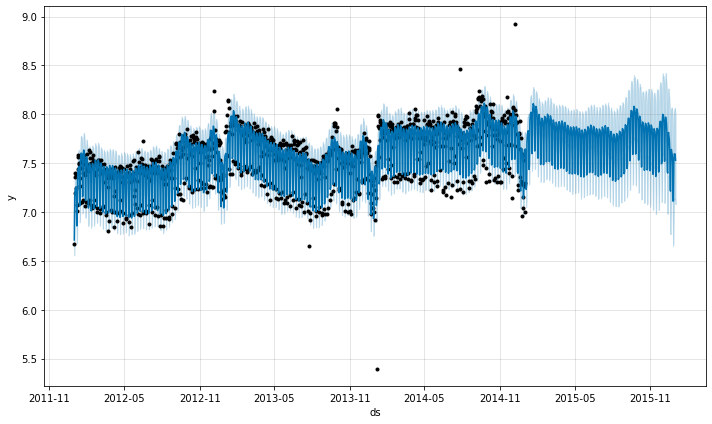

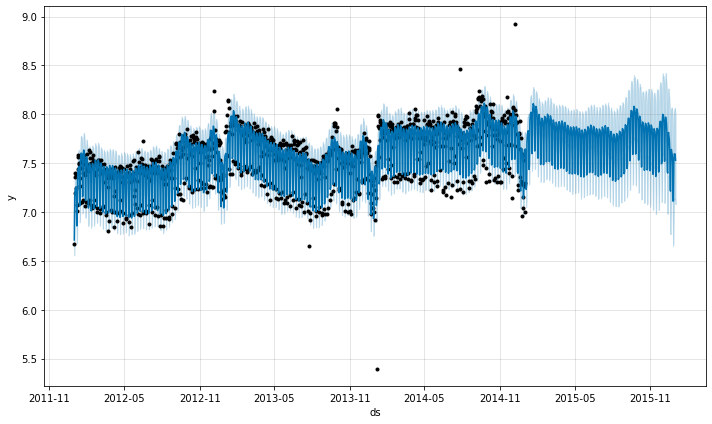

In [93]:
fmodel.plot(forecast)

ts_full

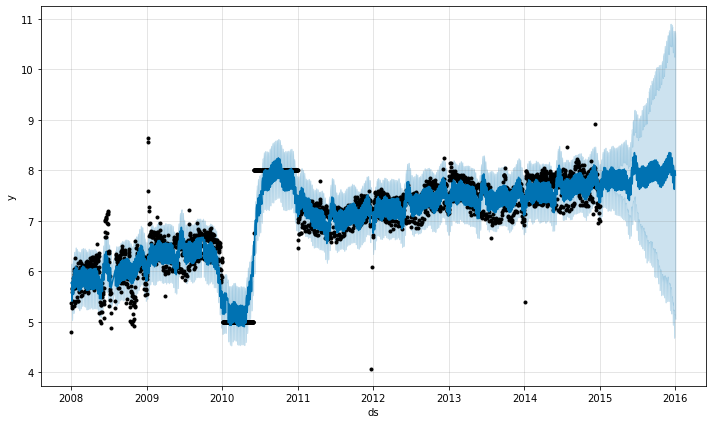

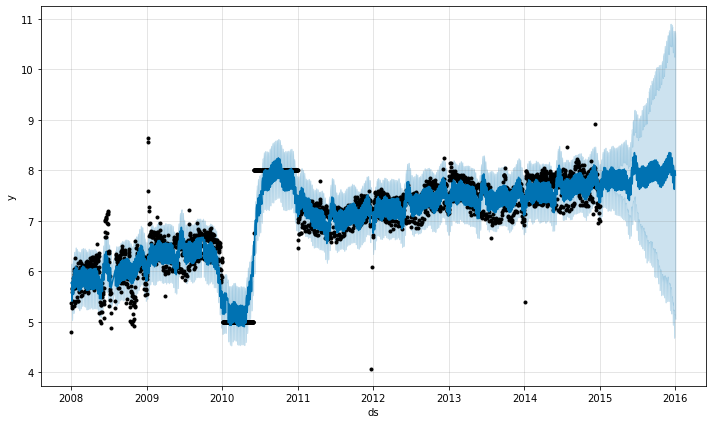

In [94]:
fmodel1.plot(forecast1)

#### Автоматическая работа с пропущенными значениями (25%)

На самом деле, библиотека Facebook Prophet умеет работать с пропущенными значениями. Создайте копию `ts_copy` ряда `ts_full` и замените в ней значения с 2010-01-01 по 2011-01-01 на `None`.

In [95]:
ts_copy = ts_full.copy()
ts_copy['y'][datetime(2010,1,1):datetime(2011,1,1)] = None
ts_copy[datetime(2010,1,1):datetime(2011,1,1)]

,ds,y
ds,,
2010-01-01,2010-01-01,NaN
2010-01-02,2010-01-02,NaN
2010-01-03,2010-01-03,NaN
2010-01-04,2010-01-04,NaN
2010-01-05,2010-01-05,NaN
...,...,...
2010-12-28,2010-12-28,NaN
2010-12-29,2010-12-29,NaN
2010-12-30,2010-12-30,NaN


Снова постройте прогноз на год вперед, но теперь на основании `ts_copy`.

In [97]:
fmodel2 = Prophet()

fmodel2.fit(ts_copy)
future2 = fmodel2.make_future_dataframe(periods=365)

forecast2 = fmodel2.predict(future2)

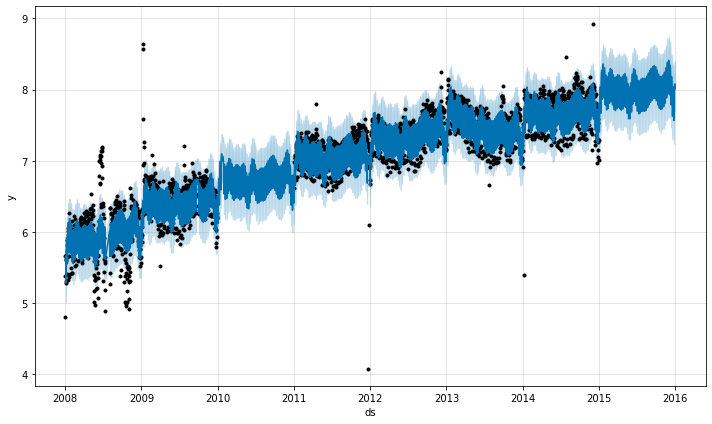

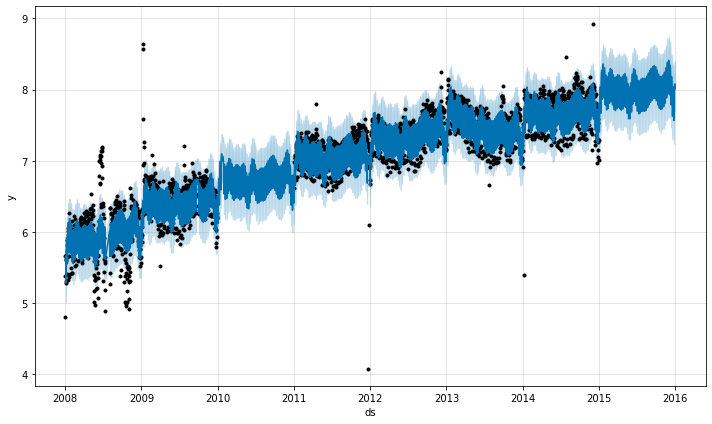

In [98]:
fmodel2.plot(forecast2)

Оцените качество прогноза с помощью MSE, MAE и $r^2$-score. Стал ли прогноз лучше? Что стало с дисперсие прогноза?

In [99]:
cmp_df  = make_comparison_dataframe(ts_copy, forecast2)

In [100]:
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MSE {}'.format(np.mean(abs(cmp_df[datetime(2015,1,1):]['p']))))
print('MAE {}'.format(np.mean(abs(cmp_df[datetime(2015,1,1):]['e']))))

MSE 11.201810434208527
MAE 0.7845719056566676


Средняя ошибка возросла при пропущенных данных, следовательно алгоритм стал хуже предсказывать.

#### Добавление информации о выходных днях.
Добавьте информацию о выходных днях (суббота и воскресенье). Для этого может быть полезен [вот этот ноутбук](https://github.com/facebook/prophet/blob/master/notebooks/seasonality%2C_holiday_effects%2C_and_regressors.ipynb) в качестве примера (`lower_window` и `upper_window` нам неактуальны, т.к. выходные не имеют локального влияния). 

_Обращаем ваше внимание: если не указать даты особых дней в будущем (т.е. внутри горизонта прогнозирования), то они не будут использованы при построении прогноза. Т.е. нужно указывать и даты в будущем_.

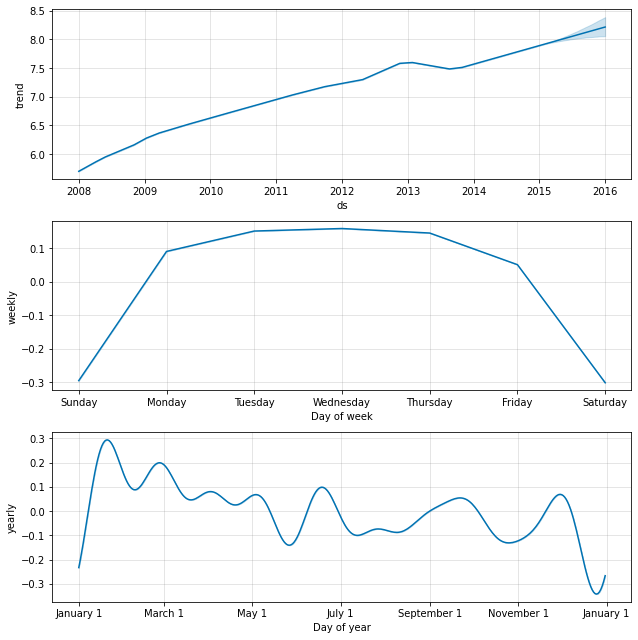

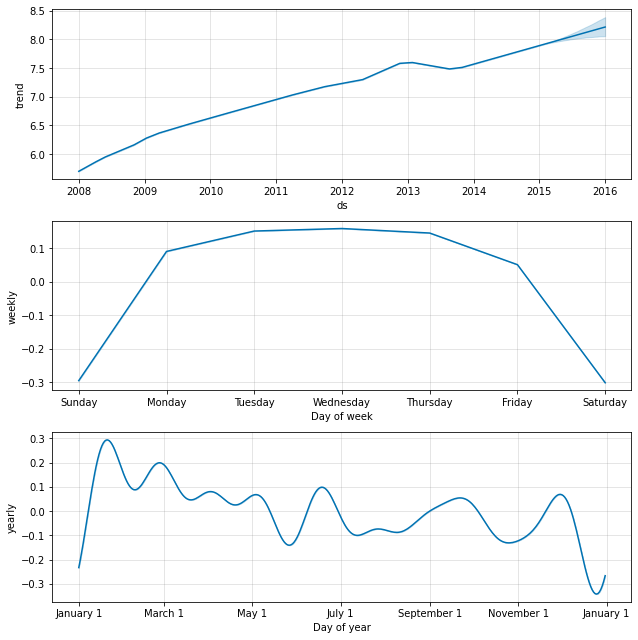

In [101]:
fmodel2.plot_components(forecast2)